In [1]:
from transformers import AutoModelForMaskedLM, TrainingArguments, Trainer, AutoTokenizer
import torch

from lava import LavaModel
model = LavaModel.from_lava_pretrained('roberta-base', 'facebook/bart-base')

from utils.datasets_config import get_dataset

dset = get_dataset('gigaword', 'facebook/bart-base')
print(dset)

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')




Some weights of BartForQuestionAnswering were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You passed along `num_labels=3` with an incompatible id to label map: {0: 'LABEL_0', 1: 'LABEL_1'}. The number of labels wil be overwritten to 2.
Found cached dataset gigaword (/home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-6816d5b30b6eeb9a.arrow
Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-6aeaeef7bff602c5.arrow
Loading cached processed dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-29041409e3286f61.arrow


Number of gigaword training examples: 3803957
Number of gigaword validation examples: 189651
Number of gigaword testing examples: 1951
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 3803957
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 189651
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'input_texts', 'label_texts'],
        num_rows: 1951
    })
})


In [2]:
training_args = TrainingArguments(
    # evaluation_strategy = "steps",
    output_dir= 'lava-ce',
    overwrite_output_dir=True,
    num_train_epochs=1,
    max_steps = 700_000,
    per_device_train_batch_size=4,
    save_steps=5_000,
    save_total_limit=20,
    prediction_loss_only=True,
    dataloader_num_workers=4,
    # learning_rate=3e-4,
    # logging_steps = 5,
    # eval_steps = 5,
    # metric_for_best_model = 'f1',
    # load_best_model_at_end=True,
)


In [3]:
def collate(batch):
    batch = ({k: torch.nn.utils.rnn.pad_sequence([dic[k] for dic in batch], batch_first=True, padding_value=1) for k in batch[0]})
    # batch['input_ids'][batch['input_ids'] == -100] = 1
    batch['attention_mask'] = (batch['input_ids'] != 1).long()
    batch['labels'][batch['labels']==1] = -100
#     batch['labels'] = torch.nn.functional.pad(batch['labels'], (0, batch['input_ids'].shape[1] - batch['labels'].shape[1], 0, 0), 'constant', 1)
    return batch

In [4]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = dset['train'].shuffle(1234),
    eval_dataset = dset['validation'].shard(300, 1),
    data_collator = collate,
    # compute_metrics = lambda x: print(x),
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=7)],
)


Loading cached shuffled indices for dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-aac49639e82619d5.arrow
max_steps is given, it will override any value given in num_train_epochs


In [5]:
trainer._load_from_checkpoint('/home/ruihan/Downloads/or/seq2seq-ngram/lava-ce/checkpoint-15000')

Loading model from /home/ruihan/Downloads/or/seq2seq-ngram/lava-ce/checkpoint-15000.


In [6]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `LavaModel.forward` and have been ignored: input_texts, label_texts. If input_texts, label_texts are not expected by `LavaModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 633
  Batch size = 8


{'eval_loss': 0.7295851111412048,
 'eval_runtime': 5.4059,
 'eval_samples_per_second': 117.095,
 'eval_steps_per_second': 14.799}

In [28]:
d = next(iter(dset['train'].shard(300, 1).shuffle()))
decoder_input_ids = (d['labels'] == 1).long()

Loading cached shuffled indices for dataset at /home/ruihan/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6/cache-7fcda05b50073be4.arrow


In [29]:
o = model(
    input_ids = d['input_ids'].cuda().unsqueeze(0),
    attention_mask = d['attention_mask'].cuda().unsqueeze(0),
)

In [30]:
d

{'input_ids': tensor([    0, 14746,    10,  9303,  1437,  1437,    10, 47385,    76,   793,
          3331,    31,    92,  1423,  9657,  1437,  1437,  1276,     7,   120,
           244,    13,    39,   292,    76,  7530,     7,  2400, 27621,  1437,
          1437,    89,    21,   269,   129,    65,  1973,  1437,  1437,     2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([    0,  4651,  1319,     7, 30686,  7530,  1437,   579, 11155,     2])}

In [31]:
o.logits.argmax(2)

tensor([[    0, 14746,    10,  9303,  1437,  1437,    10, 47385,    76,   793,
          3331,    31,    92,  1423,  9657,  1437,  1437,  1276,     7,   120,
           244,    13,    39,   292,    76,  7530,     7,  2400, 27621,  1437,
          1437,    89,    21,   269,   129,    65,  1973,  1437,  1437,     2,
             0,   102,     7,  2400,  7530,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]],
       device='cuda:0')

In [32]:
tokenizer.decode(o.logits.argmax(2).tolist()[0], skip_special_tokens=False)


'<s>when aaron   a ## year old writer from new york   decided to get help for his five year addiction to painkillers   there was really only one option  </s><s>a to pain addiction</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [33]:
print(tokenizer.decode(d['input_ids'], skip_special_tokens=True))
print()
print(tokenizer.decode(d['labels'], skip_special_tokens=True))

when aaron   a ## year old writer from new york   decided to get help for his five year addiction to painkillers   there was really only one option  

new ways to loosen addiction  s grip


In [34]:
scores = model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['input_ids']).cuda().unsqueeze(0)).end_logits
scores

tensor([[-2.3823, -3.0305, -3.7703, -3.6044, -2.9841, -1.4526, -1.3365, -1.3019,
         -1.2954, -1.2975, -1.3072, -1.2955, -1.2535, -1.2013, -1.1442, -1.0286,
         -0.7552, -0.3130,  0.2272,  0.7026,  0.8416,  1.2026,  1.9304,  2.2266,
          2.2341,  2.1247,  1.9854,  1.8436,  1.7060,  1.5816,  1.4733,  1.3784,
          1.2870,  1.2058,  1.1305,  1.0628,  1.0027,  0.9465,  0.8960,  0.8465]],
       device='cuda:0', grad_fn=<CloneBackward0>)

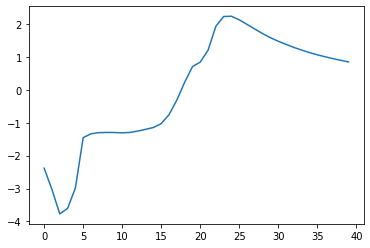

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(scores.tolist()[0])

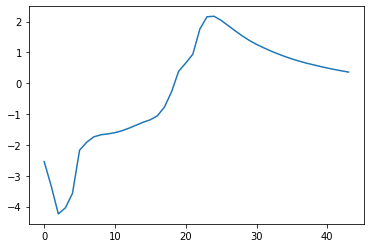

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(scores.tolist()[0])

In [14]:
model.decoder(input_ids = d['input_ids'].cuda().unsqueeze(0), decoder_input_ids = 50264 * torch.ones_like(d['labels']).cuda().unsqueeze(0)).end_logits

tensor([[-2.5963, -3.4265, -4.3493, -4.0767, -3.5718, -1.8276, -1.4692, -1.3355,
         -1.3202]], device='cuda:0', grad_fn=<CloneBackward0>)